In [78]:
import liana 
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import anndata
import scanpy as sc
from liana.mt import rank_aggregate
from liana.mt import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import numpy as np
from matplotlib.pyplot import figure
import math
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.gridspec as grid_spec

%matplotlib inline

# Data PreProcessing

# Dataset 2: Mouse Data (Figure 4)

In [2]:
#matrix = pd.read_csv("../data/GSE95025/GSM2494785_dge_mel_rep3.txt",sep="\t")
matrix = pd.read_csv("../../data/GraphComm_Input/Mouse/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

#meta = pd.read_csv("../data/Pre_Post/GSE150949_metaData_with_lineage.txt",sep="\t")

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

         Falling back to preprocessing with `sc.pp.pca` and default params.


<ipython-input-2-2a55ce2b100d>:14: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https:/

<ipython-input-2-2a55ce2b100d>:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [3]:
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)

Generating ligand-receptor stats for 2304 samples and 9531 features


In [4]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)

Generating ligand-receptor stats for 2304 samples and 9531 features


In [5]:
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

Generating ligand-receptor stats for 2304 samples and 9531 features


## load data trained on the full Omnipath set, and just the LIANA consensus

In [6]:
consensus_data=pd.read_csv("../../data/GraphComm_Output/consensus_Mouse/CCI.csv")
input_data=pd.read_csv("../../data/GraphComm_Output/Mouse/CCI.csv")
full_input_data = input_data.copy()

## identify overlapping interactions across all validated interactions from GraphComm results & other methods

In [7]:
connectome_df = connectome_df[["ligand","receptor","expr_prod"]][["ligand","receptor"]]
cellchat_df = cellchat_df[["ligand","receptor","lr_probs"]][["ligand","receptor"]]
cellphone_df = cellphone_df[["ligand","receptor","lr_means"]][["ligand","receptor"]]

In [8]:
connectome_df = connectome_df.drop_duplicates(["ligand","receptor"],keep="first")
cellchat_df = cellchat_df.drop_duplicates(["ligand","receptor"],keep="first")
cellphone_df = cellphone_df.drop_duplicates(["ligand","receptor"],keep="first")

In [9]:
full_connectome_df = connectome_df.copy()
full_cellchat_df = cellchat_df.copy()
full_cellphone_df = cellphone_df.copy()

In [10]:
intercell = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv",index_col=0)
intercell.columns = ["source","target"]

In [11]:
consensus_data=pd.merge(consensus_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
input_data=pd.merge(input_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
connectome_df=pd.merge(connectome_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellchat_df=pd.merge(cellchat_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellphone_df=pd.merge(cellphone_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])

In [12]:
full_connectome_df = connectome_df.copy()
full_cellchat_df = cellchat_df.copy()
full_cellphone_df = cellphone_df.copy()
full_input_data = input_data.copy()
full_consensus_df = consensus_data.copy()

In [13]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [14]:
new_consensus_data=pd.merge(consensus_data,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
new_input_data=pd.merge(input_data,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
new_connectome_df=pd.merge(connectome_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
new_cellchat_df=pd.merge(cellchat_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
new_cellphone_df=pd.merge(cellphone_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])

In [15]:
consensus_shape = new_consensus_data.shape[0]/consensus_data.shape[0]
input_shape = new_input_data.shape[0]/input_data.shape[0]

connectome_shape = new_connectome_df.shape[0]/connectome_df.shape[0]
cellchat_shape = new_cellchat_df.shape[0]/cellchat_df.shape[0]
cellphone_shape = new_cellphone_df.shape[0]/cellphone_df.shape[0]

Text(0, 0.5, 'Fraction of consensus interactions')

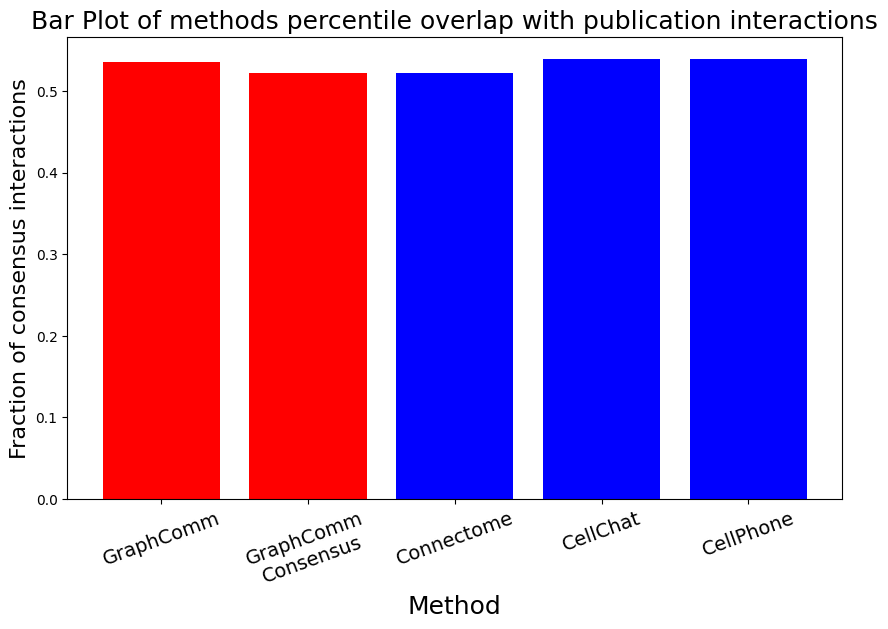

In [29]:
%matplotlib inline
plt.figure(figsize=(10,6))
#plt.bar(["GraphComm\nconsensus","GraphComm\nintracell","GraphComm\ntotal","Connectome","CellChat","CellPhone"],[consensus_shape,total_shape,intracell_shape,connectome_shape,cellchat_shape,cellphone_shape],color=["red","orange","green","blue","blue","blue"])
plt.bar(["GraphComm","GraphComm\nConsensus","Connectome","CellChat","CellPhone"],[input_shape,consensus_shape,connectome_shape,cellchat_shape,cellphone_shape],color=["red","red","blue","blue","blue"])

plt.title("Bar Plot of methods percentile overlap with publication interactions",fontdict={'fontsize':18})
plt.xticks(fontsize=14,rotation=20)

plt.xlabel("Method",fontdict={'fontsize':18})
plt.ylabel("Fraction of consensus interactions",fontdict={'fontsize':16})

In [18]:
filtered_connectome_df = pd.merge(new_connectome_df, full_connectome_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_cellphone_df = pd.merge(new_cellphone_df, full_cellphone_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_cellchat_df = pd.merge(new_cellchat_df, full_cellchat_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_input_df = pd.merge(new_input_data, full_input_data, on=['Src','Dst'], how='outer', indicator=True)
filtered_consensus_df = pd.merge(new_consensus_data, full_input_data, on=['Src','Dst'], how='outer', indicator=True)

In [19]:
filtered_connectome_df = filtered_connectome_df[filtered_connectome_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_cellchat_df = filtered_cellchat_df[filtered_cellchat_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_cellphone_df = filtered_cellphone_df[filtered_cellphone_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_input_df = filtered_input_df[filtered_input_df["_merge"]=="right_only"][["Src","Dst"]]
filtered_consensus_df = filtered_consensus_df[filtered_consensus_df["_merge"]=="right_only"][["Src","Dst"]]

## identify overlapping ligand and receptors in the top 100 interactions with the original publication

In [20]:
connectome_df = full_connectome_df.copy()
cellchat_df = full_cellchat_df.copy()
cellphone_df = full_cellphone_df.copy()

In [21]:
connectome_df = connectome_df.drop_duplicates(["ligand","receptor"],keep="first")
cellchat_df = cellchat_df.drop_duplicates(["ligand","receptor"],keep="first")
cellphone_df = cellphone_df.drop_duplicates(["ligand","receptor"],keep="first")

In [22]:
input_data=pd.merge(input_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
consensus_data =pd.merge(consensus_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
connectome_df=pd.merge(connectome_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellchat_df=pd.merge(cellchat_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellphone_df=pd.merge(cellphone_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])

In [23]:
truth = pd.read_csv("/data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [24]:
intercell = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [26]:
consensus_list = []
for i in range(0,101,5):
    temp= consensus_data.head(i)
    merged = pd.merge(temp,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
    consensus_list.append(merged.shape[0])
graphcomm_list = []
for i in range(0,101,5):
    temp= input_data.head(i)
    merged = pd.merge(temp,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
    graphcomm_list.append(merged.shape[0])
connectome_list = []
for i in range(0,101,5):
    temp= connectome_df.head(i)
    merged = pd.merge(temp,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
    connectome_list.append(merged.shape[0])
cellchat_list = []
for i in range(0,101,5):
    temp= cellchat_df.head(i)
    merged = pd.merge(temp,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
    cellchat_list.append(merged.shape[0])
cellphone_list = []
for i in range(0,101,5):
    temp= cellphone_df.head(i)
    merged = pd.merge(temp,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
    cellphone_list.append(merged.shape[0])

In [27]:
consensus_pdf =  np.array(consensus_list) / 100
graphcomm_pdf = np.array(graphcomm_list) / 100
connectome_pdf =  np.array(connectome_list) / 100
cellchat_pdf =  np.array(cellchat_list) / 100
cellphone_pdf =  np.array(cellphone_list) / 100

In [28]:
consensus_list = np.cumsum(consensus_pdf)
graphcomm_list = np.cumsum(graphcomm_pdf)
connectome_list = np.cumsum(connectome_pdf)
cellchat_list = np.cumsum(cellchat_pdf)
cellphone_list = np.cumsum(cellphone_pdf)

Text(0, 0.5, 'CDF')

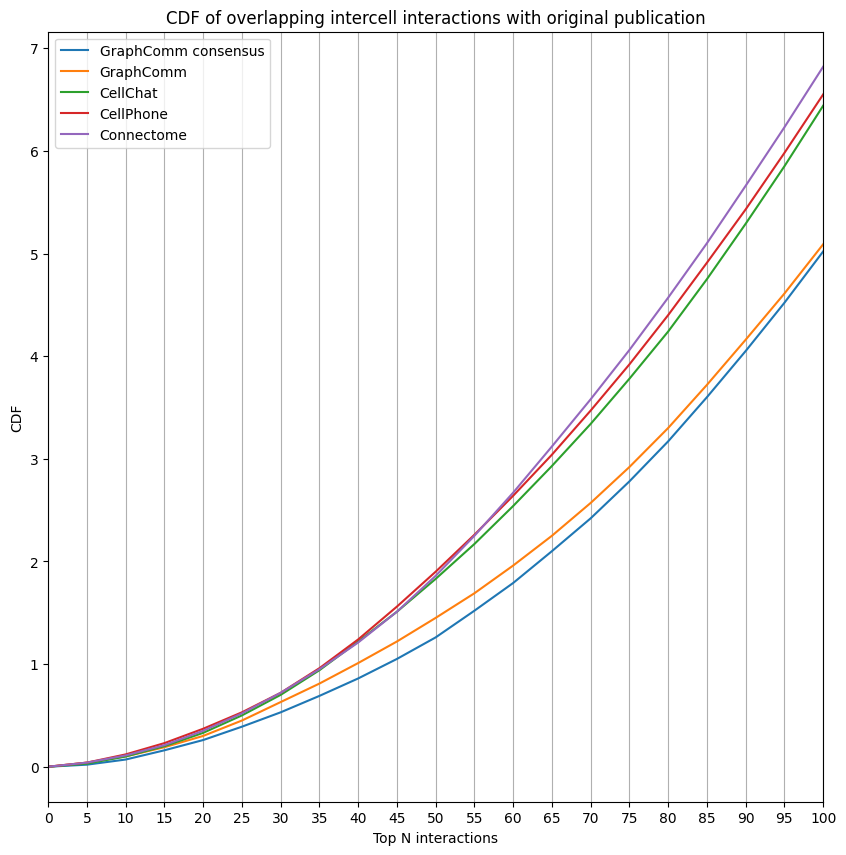

In [29]:
figure(figsize=(10,10))
plt.plot(range(0,101,5),consensus_list,markersize=15,label="GraphComm consensus")
plt.plot(range(0,101,5),graphcomm_list,label="GraphComm")
plt.plot(range(0,101,5),cellchat_list,label="CellChat")
plt.plot(range(0,101,5),cellphone_list,label="CellPhone")
plt.plot(range(0,101,5),connectome_list,label="Connectome")
plt.grid(axis = 'x')
plt.xticks(range(0,101,5))
plt.xlim((0,100))
#plt.ylim((0,1))
plt.legend()
plt.title("CDF of overlapping intercell interactions with original publication")
plt.xlabel("Top N interactions")
plt.ylabel("CDF")

# Dataset 3: Pre and Post Drug Treatment Dataset

## Day 0

In [32]:
matrix = pd.read_csv("/data/GraphComm_Input/Pre_Post/Day0/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

<ipython-input-32-2e9b9dee5c29>:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


         Falling back to preprocessing with `sc.pp.pca` and default params.


<ipython-input-32-2e9b9dee5c29>:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [33]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

Generating ligand-receptor stats for 6778 samples and 14855 features
Generating ligand-receptor stats for 6778 samples and 14855 features
Generating ligand-receptor stats for 6778 samples and 14855 features


In [34]:
day0_list = [connectome_df,cellphone_df,cellchat_df]

## Day 7 - replicate 1

In [35]:
matrix = pd.read_csv("/data/GraphComm_Input/Pre_Post/Day7_1/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

         Falling back to preprocessing with `sc.pp.pca` and default params.


<ipython-input-35-a5df57bfb3a5>:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
<ipython-input-35-a5df57bfb3a5>:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [36]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

Generating ligand-receptor stats for 4770 samples and 14573 features
Generating ligand-receptor stats for 4770 samples and 14573 features
Generating ligand-receptor stats for 4770 samples and 14573 features


In [37]:
day7_rep1_list = [connectome_df,cellphone_df,cellchat_df]

## Day 7 - replicate 2

In [38]:
#matrix = pd.read_csv("../data/GSE95025/GSM2494785_dge_mel_rep3.txt",sep="\t")
matrix = pd.read_csv("/data/GraphComm_Input/Pre_Post/Day7_2/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

#meta = pd.read_csv("../data/Pre_Post/GSE150949_metaData_with_lineage.txt",sep="\t")

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')
pval_df = pd.DataFrame.from_records(adata.uns["rank_genes_groups"]["pvals"])
pval_df.index = matrix.index.tolist()
cell_type_df = {}
for i in pval_df.columns.tolist():
    sub = pval_df[i]
    sub = sub[sub < 0.05]
    cell_type_df[i] = sub.index.tolist()

         Falling back to preprocessing with `sc.pp.pca` and default params.


<ipython-input-38-0951671f9cb5>:14: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


<ipython-input-38-0951671f9cb5>:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [39]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

Generating ligand-receptor stats for 3515 samples and 14362 features
Generating ligand-receptor stats for 3515 samples and 14362 features
Generating ligand-receptor stats for 3515 samples and 14362 features


In [40]:
day7_rep2_list = [connectome_df,cellphone_df,cellchat_df]

### pathway analysis

In [41]:
pathways = pd.read_csv("/data/LR_database/kegg_pathways.csv")

In [42]:
Omnipath_db = pd.read_csv("/data/LR_database/consensus_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_db.columns = ["from","to"]
Omnipath_db = Omnipath_db.drop_duplicates()

In [43]:
day0_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day0_list]
day7_rep1_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day7_rep1_list]
day7_rep2_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day7_rep2_list]

In [44]:
total_day7_1 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day7_1 = total_day7_1[(total_day7_1["Src"].isin(Omnipath_db["from"].tolist()))&(total_day7_1["Dst"].isin(Omnipath_db["to"].tolist()))]
total_day7_2 = total_day7_2[(total_day7_2["Src"].isin(Omnipath_db["from"].tolist()))&(total_day7_2["Dst"].isin(Omnipath_db["to"].tolist()))]
total_day0 = total_day0[(total_day0["Src"].isin(Omnipath_db["from"].tolist()))&(total_day0["Dst"].isin(Omnipath_db["to"].tolist()))]

In [45]:
pathways.index = pathways["genesymbol"].tolist()

In [46]:
day0_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day0_list]
day7_rep1_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day7_rep1_list]
day7_rep2_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day7_rep2_list]

In [47]:
total_day7_1 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day7_1 = total_day7_1[(total_day7_1["Src"].isin(pathways["genesymbol"].tolist()))&(total_day7_1["Dst"].isin(pathways["genesymbol"].tolist()))]
total_day7_2 = total_day7_2[(total_day7_2["Src"].isin(pathways["genesymbol"].tolist()))&(total_day7_2["Dst"].isin(pathways["genesymbol"].tolist()))]
total_day0 = total_day0[(total_day0["Src"].isin(pathways["genesymbol"].tolist()))&(total_day0["Dst"].isin(pathways["genesymbol"].tolist()))]

In [48]:
pathways = pathways.drop_duplicates("genesymbol")
pathways.index = pathways["genesymbol"].tolist()

In [49]:
for i in day0_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [50]:
for i in day7_rep1_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [51]:
for i in day7_rep2_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [52]:
total_day0["Ligand Pathway"] = pathways.loc[total_day0["Src"].tolist()]["pathway"].tolist()
total_day0["Receptor Pathway"] = pathways.loc[total_day0["Dst"].tolist()]["pathway"].tolist()

In [53]:
total_day7_1["Ligand Pathway"] = pathways.loc[total_day7_1["Src"].tolist()]["pathway"].tolist()
total_day7_1["Receptor Pathway"] = pathways.loc[total_day7_1["Dst"].tolist()]["pathway"].tolist()

In [54]:
total_day7_2["Ligand Pathway"] = pathways.loc[total_day7_2["Src"].tolist()]["pathway"].tolist()
total_day7_2["Receptor Pathway"] = pathways.loc[total_day7_2["Dst"].tolist()]["pathway"].tolist()

In [55]:
day0_list = [i.head(1000) for i in day0_list]
day7_rep1_list = [i.head(1000) for i in day7_rep1_list]
day7_rep2_list = [i.head(1000) for i in day7_rep2_list]

In [56]:
total_day0 = total_day0.head(1000)
total_day7_1 = total_day7_1.head(1000)
total_day7_2 = total_day7_2.head(1000)

In [57]:
grouped_day_7_1_list = [i.groupby("Receptor Pathway").count().sort_values("ligand",ascending=False) for i in day7_rep2_list]
grouped_day_7_1 = total_day7_2.groupby("Receptor Pathway").count().sort_values("Src",ascending=False)

In [58]:
grouped_day_7_1_list[0].to_csv("/results/connectome_day7_2_receptor.csv")

In [59]:
grouped_day_7_1_list[1].to_csv("/results/cellphone_day7_2_receptor.csv")

In [60]:
grouped_day_7_1_list[2].to_csv("/results/cellchat_day7_2_receptor.csv")

In [61]:
grouped_day_7_1.to_csv("/results/graphcomm_day7_2_receptor.csv")

### get unique ligand receptor interactions

In [62]:
day0_list = [i[["ligand","receptor"]].drop_duplicates() for i in day0_list]
day7_rep1_list = [i[["ligand","receptor"]].drop_duplicates() for i in day7_rep1_list]
day7_rep2_list = [i[["ligand","receptor"]].drop_duplicates() for i in day7_rep2_list]

In [63]:
original_day0 = day0_list
original_day7_rep1 = day7_rep1_list
original_day7_rep2 = day7_rep2_list


### for each method's result of each dataset, retrieve the top 50 interactions

In [64]:
day0_list = [i.head(50) for i in day0_list]
day7_rep1_list = [i.head(50) for i in day7_rep1_list]
day7_rep2_list = [i.head(50) for i in day7_rep2_list]


In [65]:
pathways = pd.read_csv("/data/LR_database/kegg_pathways.csv")

### for each method's result of each dataset, only retain intercell validated interactions

In [66]:
Omnipath_db = pd.read_csv("/data/LR_database/consensus_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_db.columns = ["from","to"]
Omnipath_db = Omnipath_db.drop_duplicates()

In [67]:
day0_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day0_list]
day7_rep1_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day7_rep1_list]
day7_rep2_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day7_rep2_list]

day0_list = [i[["ligand","receptor"]] for i in day0_list]
day7_rep1_list = [i[["ligand","receptor"]] for i in day7_rep1_list]
day7_rep2_list = [i[["ligand","receptor"]] for i in day7_rep2_list]

### for each method, capture maximum # of unique interactions between top 100 CCC interactions between pre and post treatment datasets

In [68]:
pre_post_list = []
for i,j,k in zip(day0_list,day7_rep1_list,day7_rep2_list):
    day0_day7_rep1_common = pd.merge(i,j).shape[0]/50
    day0_day7_rep2_common = pd.merge(i,k).shape[0]/50
    pre_post_list.append(min(1-day0_day7_rep1_common,1-day0_day7_rep2_common))

### import GraphComm's results, perform same preprocessing

In [69]:
total_day7_1 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day0 = pd.merge(total_day0,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]
total_day7_1 = pd.merge(total_day7_1,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]
total_day7_2 = pd.merge(total_day7_2,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]

In [70]:
total_day0_day7_1 = pd.merge(total_day0,total_day7_1).shape[0]/50
total_day0_day7_2 = pd.merge(total_day0,total_day7_2).shape[0]/50

total_pre_post = max(1-total_day0_day7_1,1-total_day0_day7_2)

Text(0, 0.5, 'Fraction of Unique Interactions')

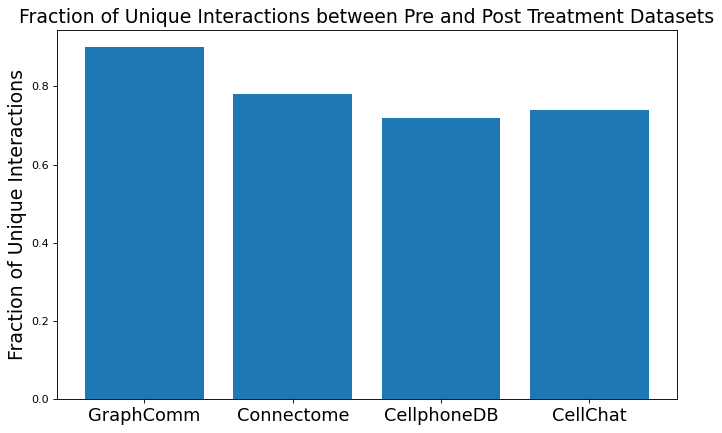

In [77]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(10,6), dpi=80)
plt.bar(["GraphComm","Connectome","CellphoneDB","CellChat"],[total_pre_post] + pre_post_list)
plt.xticks(fontsize=16)
plt.title("Fraction of Unique Interactions between Pre and Post Treatment Datasets",fontdict={'fontsize':17})
plt.ylabel("Fraction of Unique Interactions",fontdict={'fontsize':17})

## Dataset 5 - Spatial cardiovascular data (Fig 2E)

In [79]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells//Visium-FZ_GT_P19.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
matrix = pd.DataFrame.sparse.from_spmatrix(adata.X,index=adata.obs.index.tolist(),columns=adata.var["feature_name"].tolist())

meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"label":adata.obs["cell_type_original"].tolist()})
meta = meta[meta["label"] != "Lymphoid"]
meta.index = meta["cell"].tolist()

matrix = matrix.transpose()

matrix = matrix[meta.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

meta['label'] = meta["label"].astype("string").tolist()

meta["cell"] = meta["cell"].astype("category")
meta["label"] = meta["label"].astype("category")

matrix = matrix.loc[:,~matrix.columns.duplicated()].copy()
meta = meta.loc[~meta.index.duplicated(),:].copy()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

In [80]:
connectome(adata,groupby="label",expr_prop=0)
spatial_connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
spatial_cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
spatial_cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

Generating ligand-receptor stats for 3095 samples and 14078 features
Generating ligand-receptor stats for 3095 samples and 14078 features
Generating ligand-receptor stats for 3095 samples and 14078 features



### remove self-loops for cell groups

In [81]:
spatial_cellphone_df = spatial_cellphone_df[spatial_cellphone_df["source"] != spatial_cellphone_df["target"]]
spatial_cellchat_df = spatial_cellchat_df[spatial_cellchat_df["source"] != spatial_cellchat_df["target"]]
spatial_connectome_df = spatial_connectome_df[spatial_connectome_df["source"] != spatial_connectome_df["target"]]


### for each method's results, capture the top 10 unique cell group interactions

In [82]:
temp_cellphone_df = spatial_cellphone_df.drop_duplicates(["source","target"]).head(10)
temp_cellchat_df = spatial_cellchat_df.drop_duplicates(["source","target"]).head(10)
temp_connectome_df = spatial_connectome_df.drop_duplicates(["source","target"]).head(10)

### import GraphComm results, remove self loops and capture the top 10 unique cell group interactions

In [83]:
total_spatial = pd.read_csv("../../data/GraphComm_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
total_spatial = total_spatial[total_spatial["Src Cell"] != total_spatial["Dst Cell"]]
total_spatial = total_spatial.drop_duplicates(["Src Cell","Dst Cell"]).head(10)

### retrieve cell group spatial coordinates

In [84]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")


In [85]:
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"label":adata.obs["cell_type_original"].tolist()})
meta = meta[meta["label"] != "Lymphoid"]
meta.index = meta["cell"].tolist()

adata = adata[meta.index.tolist()]
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=meta.index.tolist())
cell_groups = meta["label"].unique().tolist()

### extract from each method, the average eucleadian distance for the top 10 cell group interactions

In [86]:
cellphone_spatial = []
for one,two in zip(temp_cellphone_df["source"].tolist(),temp_cellphone_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    cellphone_spatial.append(np.mean(min_list))


In [87]:
cellchat_spatial = []
for one,two in zip(temp_cellchat_df["source"].tolist(),temp_cellchat_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    cellchat_spatial.append(np.mean(min_list))


In [88]:
connectome_spatial = []
for one,two in zip(temp_connectome_df["source"].tolist(),temp_connectome_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    connectome_spatial.append(np.mean(min_list))


In [89]:
graphcomm_total_spatial = []
for one,two in zip(total_spatial["Src Cell"].tolist(),total_spatial["Dst Cell"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    graphcomm_total_spatial.append(np.mean(min_list))


### extract randomized iterations

In [90]:
df_list = []
for i in range(100):
    df_list.append(pd.read_csv(f"/data/random_data/Cardiac_Cells/spatial_{i+1}_random.csv",index_col=0).drop_duplicates(["Src Cell","Dst Cell"]))

In [91]:
random_spatial = []
for i in df_list:
    temp_input = i
    input_spatial = []
    for one,two in zip(temp_input["Src Cell"].tolist(),temp_input["Dst Cell"].tolist()):
        cells = meta[meta["label"]==one].index.tolist()
        spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
        if two != one:
            second_cells = meta[meta["label"]==two].index.tolist()
            second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
            min_list = []
            for k in spatial_coords:
                min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
            input_spatial.append(np.mean(min_list))
    random_spatial.append(input_spatial)


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


In [92]:
new_random_spatial = []
for i in random_spatial:
    new_random_spatial.append([min([k for k in i if not np.isnan(k)]) if np.isnan(j) else j for j in i])

In [93]:
random_average = []
for i in range(10):
    random_average.append(np.mean([j[i] for j in new_random_spatial]))

In [94]:
x = [connectome_spatial,cellchat_spatial,cellphone_spatial,graphcomm_total_spatial]
comparison_labels = ['Connectome',"CellChat","CellPhone","GraphComm"]
df = pd.DataFrame(x, index=comparison_labels)


### visualize via ridgeline plot

In [95]:
df

,0,1,2,3,4,5,6,7,8,9
Connectome,0.508076,0.579552,0.437746,0.513490,0.433397,0.437746,0.484351,0.511083,0.496317,0.439119
CellChat,0.579552,0.508076,0.437746,0.513490,0.433397,0.511083,0.484351,0.475336,0.496317,0.385759
CellPhone,0.508076,0.579552,0.437746,0.385759,0.484351,0.511083,0.433397,0.437746,0.417550,0.475336
GraphComm,0.385759,0.459234,0.417550,0.523165,0.397472,0.439119,0.467333,0.532791,0.437746,0.433397


In [96]:
df.median(axis=1)

Connectome    0.490334
CellChat      0.490334
CellPhone     0.456541
GraphComm     0.438432
dtype: float64

In [97]:
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

In [98]:
graphcomm_total_df = pd.DataFrame([graphcomm_total_spatial], index=["GraphComm"]).transpose()
connectome_df= pd.DataFrame([connectome_spatial], index=["Connectome"]).transpose()
cellchat_df= pd.DataFrame([cellchat_spatial], index=["CellChat"]).transpose()
cellphone_df= pd.DataFrame([cellphone_spatial], index=["CellPhone"]).transpose()

In [99]:
df_list = [connectome_df,cellchat_df,cellphone_df,graphcomm_total_df]

In [100]:
random_df = pd.DataFrame([random_average]).T
random_df.columns = ["Random"]

## scale randomization data

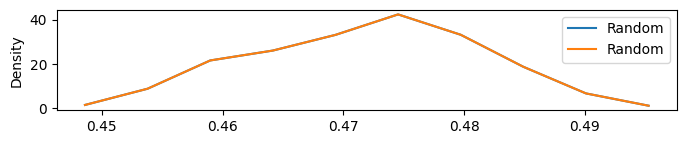

In [101]:
i = 0
gs = (grid_spec.GridSpec(len(comparison_labels),1))

fig = plt.figure(figsize=(8,6))
ax_objs = []
ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
random_x = random_df.plot.kde(ax=ax_objs[-1],ind=10).get_children()[0]._x
random_y= random_df.plot.kde(ax=ax_objs[-1],ind=10).get_children()[0]._y
random_y = random_y / 4

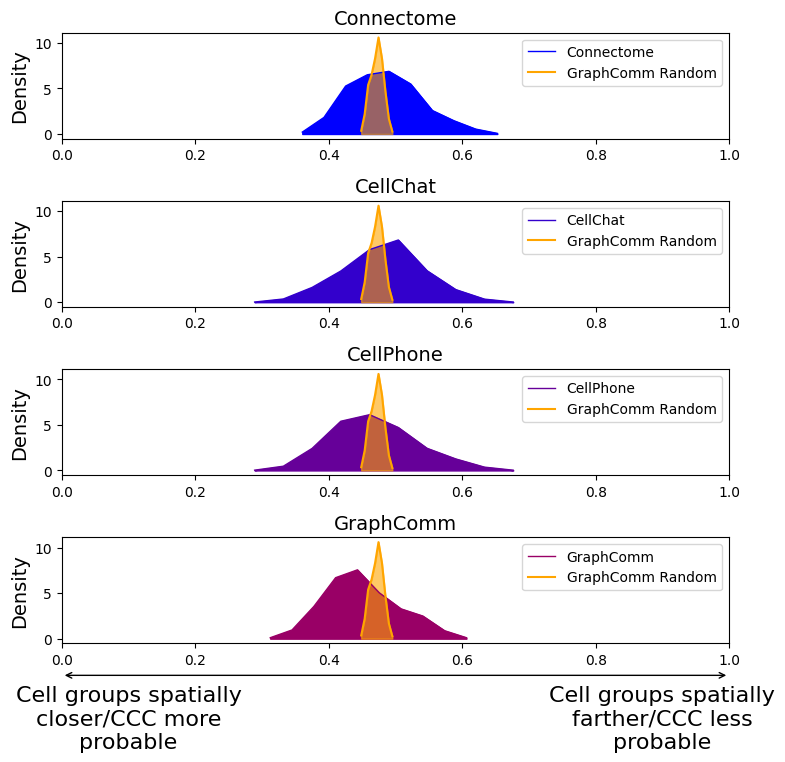

In [116]:
import matplotlib.gridspec as grid_spec
%matplotlib inline
gs = (grid_spec.GridSpec(len(comparison_labels),1))

fig = plt.figure(figsize=(8,8))

i = 0

#creating empty list
ax_objs = []

for df,label in zip(df_list,comparison_labels):
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = (df.plot.kde(ax=ax_objs[-1],color=colors[i], lw=1,ind=10)
           )

    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].plot(random_x,random_y,color="orange",label="GraphComm Random")
    plot.legend()
    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x,y,color=colors[i])
    ax_objs[-1].fill_between(random_x,random_y,color="orange",alpha=0.6)

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,1)
    #ax_objs[-1].set_ylim(0,10)
    ax_objs[-1].set_title(label,fontdict={"fontsize":14})
    ax_objs[-1].set_ylabel("Density",fontdict={"fontsize":14})
    i += 1
plt.annotate('', xy=(0, -0.3), xycoords='axes fraction', xytext=(1, -0.3), 
            arrowprops=dict(arrowstyle="<->"))
plt.text(0.1,-12, 'Cell groups spatially\ncloser/CCC more\nprobable',ha="center",fontdict={"fontsize":16})
plt.text(0.9,-12, 'Cell groups spatially\nfarther/CCC less\nprobable',ha="center",fontdict={"fontsize":16})
plt.tight_layout()
plt.show()